# Pairwise distance analysis with Plink

_Note: This Notebook is using the R Kernel._

You have already seen one way to visualise genotype data in low dimensions, using smartPCA. We now turn to another method, called MDS and implemented in the software package [Plink](https://zzz.bwh.harvard.edu/plink/).

We will first have to convert the EIGENSTRAT-formatted genotype data that we produced via `trident forge` to Plink format. We can do that using `trident genoconvert`. Open a terminal window in jupyter (up on the left, the button with the plus sign, and then Terminal), and run

```{bash}
trident genoconvert -d scratch/forged_package --outFormat PLINK
```

We can now find the PLINK data in the same directory as the EIGENSTRAT data. Check it out by inspecting the file browser in Jupyter, or by running in the terminal:

```{bash}
ls scratch/forged_package/
```

Where the `.bed`, `.bim` and `.fam` files are used in PLINK. In fact, they are automatically used whenever you use the option `--bfile forged_package/PCA_package` in plink. The first command we're gonna use is for computing pairwise distances of all individuals:

```{bash}
plink --bfile scratch/forged_package/PCA_package_1 --distance-matrix --out scratch/pairwise_distances
```

Now we can do stuff in R. Let's first load the individuals.

In [28]:
inds <- readr::read_tsv("scratch/pairwise_distances.mdist.id", col_types="cc", col_names=c("Population", "Individual"))

In [29]:
inds

Population,Individual
<chr>,<chr>
French,HGDP00511
French,HGDP00512
French,HGDP00513
French,HGDP00514
French,HGDP00515
French,HGDP00516
French,HGDP00517
French,HGDP00518
French,HGDP00519


In [33]:
dist_mat <- matrix(scan("scratch/pairwise_distances.mdist"), ncol=1666)

In [34]:
dim(dist_mat)

[1] 1666 1666

We can play a bit with trying to visualizing that massive 1666x1666 matrix, for example using the function `heatmap`:

In [38]:
?heatmap

heatmap {stats},R Documentation
x,numeric matrix of the values to be plotted.
Rowv,"determines if and how the row dendrogram should be computed and reordered. Either a dendrogram or a vector of values used to reorder the row dendrogram or NA to suppress any row dendrogram (and reordering) or by default, NULL, see ‘Details’ below."
Colv,"determines if and how the column dendrogram should be reordered. Has the same options as the Rowv argument above and additionally when x is a square matrix, Colv = ""Rowv"" means that columns should be treated identically to the rows (and so if there is to be no row dendrogram there will not be a column one either)."
distfun,function used to compute the distance (dissimilarity) between both rows and columns. Defaults to dist.
hclustfun,function used to compute the hierarchical clustering when Rowv or Colv are not dendrograms. Defaults to hclust. Should take as argument a result of distfun and return an object to which as.dendrogram can be applied.
reorderfun,"function(d, w) of dendrogram and weights for reordering the row and column dendrograms. The default uses reorder.dendrogram."
add.expr,expression that will be evaluated after the call to image. Can be used to add components to the plot.
symm,logical indicating if x should be treated symmetrically; can only be true when x is a square matrix.
revC,"logical indicating if the column order should be reversed for plotting, such that e.g., for the symmetric case, the symmetry axis is as usual."
scale,"character indicating if the values should be centered and scaled in either the row direction or the column direction, or none. The default is ""row"" if symm false, and ""none"" otherwise."


Let's first try and filter for a few populations:

In [40]:
unique(inds$Population)

[1] "French"                    "Druze"                    
  [3] "BedouinB"                  "BedouinA"                 
  [5] "Sardinian"                 "Palestinian"              
  [7] "Cambodian"                 "Japanese"                 
  [9] "Han"                       "Orcadian"                 
 [11] "Surui"                     "Russian"                  
 [13] "Yakut"                     "Karitiana"                
 [15] "Pima"                      "Tujia"                    
 [17] "Italian_North"             "Yi"                       
 [19] "Miao"                      "Oroqen"                   
 [21] "Daur"                      "Mongola"                  
 [23] "Hezhen"                    "Xibo"                     
 [25] "Uyghur"                    "Dai"                      
 [27] "China_Lahu"                "She"                      
 [29] "Naxi"                      "Tu"                       
 [31] "Basque"                    "Adygei"                   
 [33] "Eskimo_Naukan"             "Chukchi"                  
 [35] "Nganasan"                  "Mixe"                     
 [37] "Saami.WGA"                 "Yukagir"                  
 [39] "Chukchi1"                  "Ulchi"                    
 [41] "Tubalar"                   "Even"                     
 [43] "Eskimo_ChaplinSireniki"    "Koryak"                   
 [45] "Itelmen"                   "Bulgarian"                
 [47] "Hungarian"                 "Lithuanian"               
 [49] "Iranian"                   "Syrian"                   
 [51] "Lebanese"                  "Jordanian"                
 [53] "Saudi"                     "Balkar"                   
 [55] "Georgian"                  "Ossetian"                 
 [57] "Chechen"                   "Abkhasian"                
 [59] "Armenian"                  "Lezgin"                   
 [61] "Nogai_Karachay_Cherkessia" "Kumyk"                    
 [63] "Kalmyk"                    "Altaian"                  
 [65] "Tuvinian"                  "Dolgan"                   
 [67] "Selkup"                    "Belarusian"               
 [69] "Ukrainian"                 "Estonian"                 
 [71] "Mordovian"                 "Chuvash"                  
 [73] "Uzbek"                     "Tajik"                    
 [75] "Turkmen"                   "Atayal"                   
 [77] "Ami"                       "Czech"                    
 [79] "Icelandic"                 "Greek"                    
 [81] "Korean"                    "Scottish"                 
 [83] "English"                   "Spanish"                  
 [85] "Spanish_North"             "Finnish"                  
 [87] "Kinh"                      "Thai"                     
 [89] "Zapotec"                   "Mixtec"                   
 [91] "Jew_Libyan"                "Maltese"                  
 [93] "Croatian"                  "Jew_Ashkenazi"            
 [95] "Jew_Turkish"               "Norwegian"                
 [97] "Jew_Tunisian"              "Sicilian"                 
 [99] "Italian_South"             "Jew_Yemenite"             
[101] "Turkish"                   "Jew_Iranian"              
[103] "Albanian"                  "Mansi"                    
[105] "Jew_Iraqi"                 "Cypriot"                  
[107] "Jew_Moroccan"              "Jew_Georgian"             
[109] "Kyrgyz_Kyrgyzstan"         "Aleut"                    
[111] "Russia_MA1_HG.SG"          "Azeri"                    
[113] "Buryat"                    "Avar"                     
[115] "Kurd"                      "Mongol"                   
[117] "Nogai_Astrakhan"           "Nogai_Stavropol"          
[119] "Kyrgyz_Tajikistan"

In [42]:
indices <- inds$Population %in% c('French', 'Greek', 'Nganasan')
indices

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [25]  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [529] FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE
 [541] FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
 [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
 [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [601] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALS

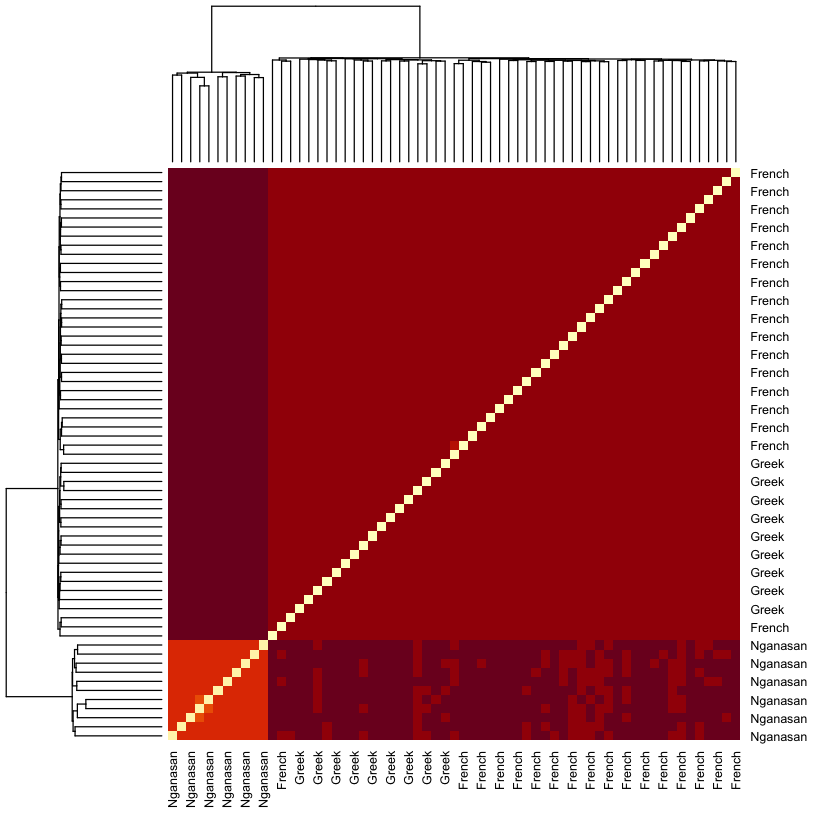

In [43]:
heatmap(dist_mat[indices,indices], labRow = inds$Population[indices], labCol = inds$Population[indices])